# Ecosystem Productivity Responses to Atmospheric Dryness: A GPP–ET–VPD Coupling Analysis (2016–2020)

# 0. Requirement and Notebook Setup

Final Project (30%)
The goal of the final project is to assess your ability to combine and apply the skills you have learned in class in the context of a real-world research problem. Our class has mostly focused on tools for environmental data analysis, so this must be the focus of your final project. Specifically, we seek to assess your ability to do the following tasks:
* Discover and download real datasets in standard formats (e.g. CSV, netCDF)
* Load the data into pandas or xarray, performing any necessary data cleanup (dealing with missing values, proper time encoding, etc.) along the way.
* Perform realistic scientific calculation involving, for example tasks such as data grouping, aggregating, correlation analysis, trend analysis.
* Visualize your results in well-formatted plots.
* Clearly document your analysis to make it reproducible.
* Publish your final project as a GitHub repository.

In [2]:
import pandas as pd
import numpy as np
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 1.Introduction

**Purpose.**

Ecosystem productivity (GPP) is strongly regulated by both water loss (ET) and atmospheric dryness (VPD). Increasing VPD linked to warming climate can suppress photosynthesis, especially during dry seasons.

In this project, we investigate the temporal coupling among:

- **GPP (Gross Primary Productivity)**
- **ET (Evapotranspiration)**
- **VPD (Vapor Pressure Deficit)**

for **2016–2020**, using from two SMAP products: (i) the SMAP Level-4 surface and root-zone soil moisture product and (ii) the SMAP Level-4  Carbon product.

**Questions we aim to answer:**

1. How do global mean GPP, ET, and VPD change over 2016–2020?
2. Is GPP more strongly correlated with ET or with VPD?
3. How does seasonality shape the coupling among GPP, ET, and VPD?
4. Do these relationships differ by season (dry vs wet months)?
5. What spatial patterns reveal hotspots of VPD stress or strong ET–GPP coupling?

# 2. Data Loading & Preprocessing

## 2.1. Load SMAP GPP

In [3]:
# GPP
path1 = "/scratch/f_cc2127_1/tongliu/Data/interim/000_smap_c_monthly/*.nc"
files1 = sorted(glob(path1))
gpp_ds = xr.open_mfdataset(files1, combine='nested', concat_dim='time')['gpp_mean'][:60]
gpp_ds

<xarray.DataArray 'gpp_mean' (time: 60, y: 1817, x: 3776)> Size: 3GB
dask.array<getitem, shape=(60, 1817, 3776), dtype=float64, chunksize=(1, 1817, 3776), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 30kB -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * y        (y) float64 15kB 85.42 85.32 85.23 85.13 ... -87.53 -87.63 -87.72
Dimensions without coordinates: time
Attributes:
    units:         µmol C m-2 s-1
    long_name:     Global monthly daily 9km Gross Primary Productivity (GPP) ...
    grid_mapping:  spatial_ref

## 2.2. Load SMAP ET

In [5]:
#  ET
path3 = "/scratch/f_cc2127_1/tongliu/Data/interim/000_monthly_derived/*.nc"
files3 = sorted(glob(path3))
et_ds = xr.open_mfdataset(files3, combine='nested', concat_dim='time')['E_mol']
et_ds

<xarray.DataArray 'E_mol' (time: 60, y: 1817, x: 3776)> Size: 2GB
dask.array<concatenate, shape=(60, 1817, 3776), dtype=float32, chunksize=(1, 1817, 3776), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 30kB -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * y        (y) float64 15kB 85.42 85.32 85.23 85.13 ... -87.53 -87.63 -87.72
  * time     (time) datetime64[ns] 480B 2016-01-16T12:00:00 ... 2020-12-16T12...
Attributes:
    units:         mol m-2 s-1
    long_name:     Water vapor molar
    grid_mapping:  spatial_ref

## 2.3. Load SMAP VPD

In [6]:
# VPD
vpd_ds = xr.open_mfdataset(files3, combine='nested', concat_dim='time')['D']
vpd_ds

<xarray.DataArray 'D' (time: 60, y: 1817, x: 3776)> Size: 2GB
dask.array<concatenate, shape=(60, 1817, 3776), dtype=float32, chunksize=(1, 1817, 3776), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 30kB -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * y        (y) float64 15kB 85.42 85.32 85.23 85.13 ... -87.53 -87.63 -87.72
  * time     (time) datetime64[ns] 480B 2016-01-16T12:00:00 ... 2020-12-16T12...
Attributes:
    units:         mol mol–1
    long_name:     vapor pressure deficit in mol
    grid_mapping:  spatial_ref

## 2.4. Compute Global Area-Weighted Means

In [7]:
weights = np.cos(np.deg2rad(gpp_ds["y"]))

gpp_ts = (gpp_ds * weights).mean(dim=("y","x"))
et_ts  = (et_ds  * weights).mean(dim=("y","x"))
vpd_ts = (vpd_ds * weights).mean(dim=("y","x"))

In [11]:
# Convert to a dataframe：
df = pd.DataFrame({
    "time": et_ds["time"].values,
    "GPP": gpp_ts.values,
    "ET": et_ts.values,
    "VPD": vpd_ts.values,
})
df["month"] = df["time"].dt.month
df["year"]  = df["time"].dt.year

In [12]:
df

,time,GPP,ET,VPD,month,year
0,2016-01-16 12:00:00,1.555997,0.000578,0.005134,1,2016
1,2016-02-15 12:00:00,1.659552,0.000623,0.006003,2,2016
2,2016-03-16 12:00:00,1.733678,0.000660,0.006411,3,2016
3,2016-04-16 00:00:00,1.955028,0.000739,0.007477,4,2016
4,2016-05-16 12:00:00,2.407140,0.000861,0.007921,5,2016
5,2016-06-16 00:00:00,2.961824,0.001000,0.008855,6,2016
6,2016-07-16 12:00:00,3.100660,0.001032,0.008915,7,2016
7,2016-08-16 12:00:00,2.841175,0.000949,0.008883,8,2016
8,2016-09-16 00:00:00,2.310294,0.000785,0.008088,9,2016
9,2016-10-16 12:00:00,1.849455,0.000667,0.007166,10,2016


# 3.Time Series Analysis

## 3.1. Plot GPP, ET, VPD time series

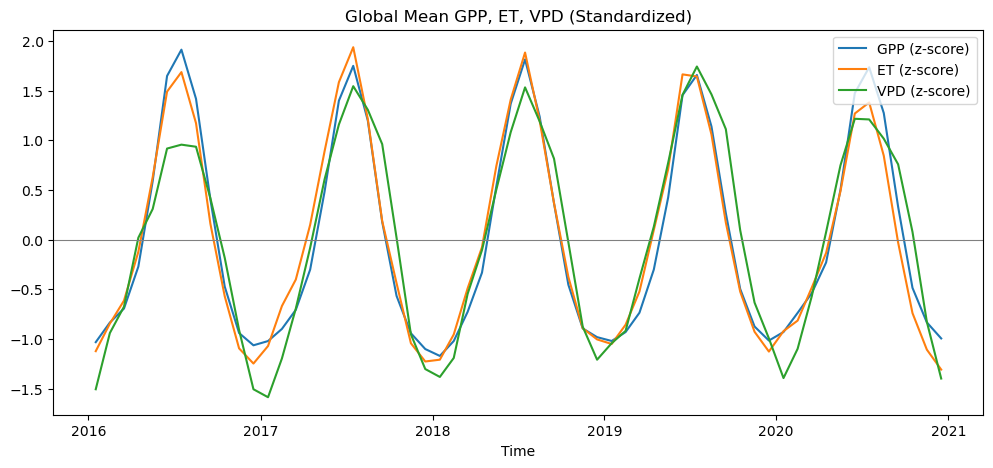

In [13]:
plt.figure(figsize=(12,5))

# Because GPP, ET, and VPD are in different physical units and magnitudes
# All variables were standardized into z-scores before plotting.
plt.plot(df["time"], (df["GPP"] - df["GPP"].mean())/df["GPP"].std(), label="GPP (z-score)")
plt.plot(df["time"], (df["ET"]  - df["ET"].mean()) /df["ET"].std(), label="ET (z-score)")
plt.plot(df["time"], (df["VPD"] - df["VPD"].mean())/df["VPD"].std(), label="VPD (z-score)")
plt.axhline(0, color='gray', linewidth=0.8)

plt.legend()
plt.xlabel("Time")
plt.title("Global Mean GPP, ET, VPD (Standardized)")
plt.show()

## 3.2. Monthly Climatology & Seasonal Cycle

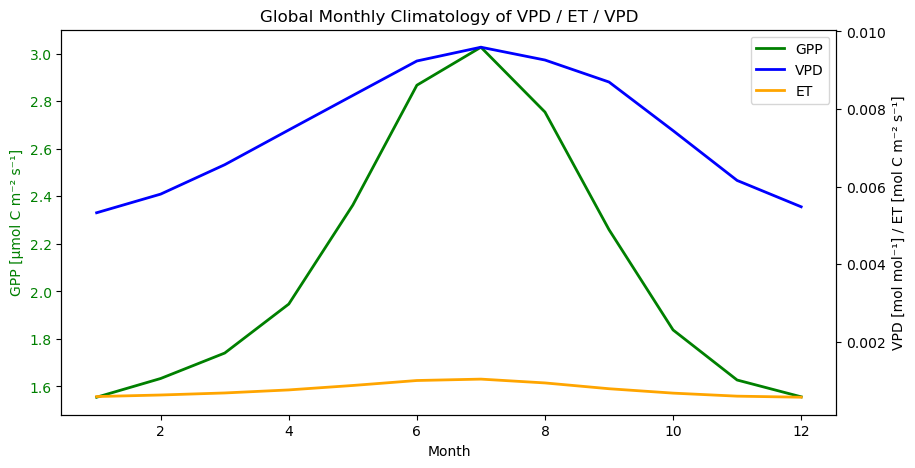

In [14]:
clim = df.groupby("month")[["GPP","ET","VPD"]].mean()

fig, ax1 = plt.subplots(figsize=(10,5))

# --- left ax：GPP ---
ax1.plot(clim.index, clim["GPP"], color="green", label="GPP", linewidth=2)
ax1.set_xlabel("Month")
ax1.set_ylabel("GPP [µmol C m⁻² s⁻¹]", color="green")
ax1.tick_params(axis="y", labelcolor="green")

# --- Right ax：VPD & ET ---
ax2 = ax1.twinx()
ax2.plot(clim.index, clim["VPD"], color="blue", label="VPD", linewidth=2)
ax2.plot(clim.index, clim["ET"], color="orange", label="ET", linewidth=2)

ax2.set_ylabel("VPD [mol mol⁻¹] / ET [mol C m⁻² s⁻¹]", color="black")
ax2.tick_params(axis="y", labelcolor="black")

# --- 标题 ---
plt.title("Global Monthly Climatology of VPD / ET / VPD")

# --- 合并图例 ---
lines = ax1.get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, loc="upper right")

plt.show()


## 3.3. Interpretation
Both figures show a strong and coherent seasonal coupling among GPP, ET, and VPD at the global scale. The standardized time-series reveal that all three variables rise and fall nearly synchronously each year, peaking during the Northern Hemisphere summer. The monthly climatology further shows that months with high VPD also coincide with high ET and maximal GPP, indicating that global productivity is most active when atmospheric demand and evaporative fluxes are strongest. Together, the results highlight a tightly linked seasonal cycle, where ecosystem photosynthesis, water loss, and atmospheric dryness co-vary globally.

# 4. Correlation Analysis

## 4.1 Simple correlations

In [15]:
corr_gpp_vpd = df["GPP"].corr(df["VPD"])
corr_gpp_et  = df["GPP"].corr(df["ET"])
corr_gpp_vpd, corr_gpp_et

(np.float64(0.9327362288688376), np.float64(0.9811871912785659))

## 4.2 Scatterplots

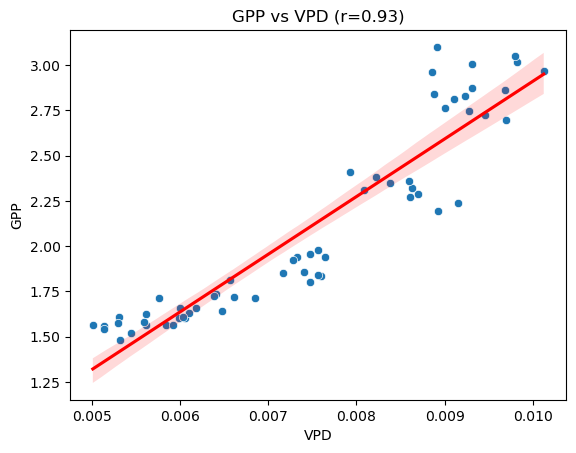

In [16]:
sns.scatterplot(data=df, x="VPD", y="GPP")
sns.regplot(data=df, x="VPD", y="GPP", scatter=False, color="red")
plt.title(f"GPP vs VPD (r={corr_gpp_vpd:.2f})")
plt.show()

Text(0.5, 1.0, 'GPP vs ET (r=0.98)')

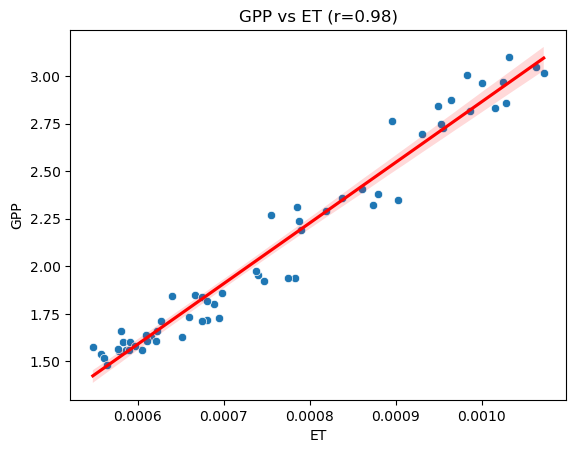

In [17]:
sns.scatterplot(data=df, x="ET", y="GPP")
sns.regplot(data=df, x="ET", y="GPP", scatter=False, color="red")
plt.title(f"GPP vs ET (r={corr_gpp_et:.2f})")

## 4.3 Interpretation
The two scatterplots show that global GPP is strongly correlated with both VPD and ET, but the strength of association differs.
GPP–VPD exhibits a strong positive relationship (r ≈ 0.93), reflecting the fact that VPD co-varies seasonally with temperature and radiation, which also drive photosynthesis. 

The much tighter GPP–ET correlation (r ≈ 0.98) indicates that water supply plays an even more dominant role in controlling global productivity. ET captures both stomatal conductance and ecosystem water availability, which directly constrain GPP. 

# 5. Dry-season vs Wet-season Global Comparison

Dry and wet seasons were defined based on global VPD climatology, where dry-season months exhibited the highest atmospheric dryness (top 3 VPD months), and wet-season months corresponded to the lowest VPD values. This prevents biases introduced by arbitrary calendar-based seasons that fail under global analyses.

## 5.1. Distinguish dry season and wet season

In [18]:
# Define dry season and wet season
wet_months = clim["VPD"].nsmallest(3).index.tolist()
dry_months = clim["VPD"].nlargest(3).index.tolist()

wet_months, dry_months

([1, 12, 2], [7, 8, 6])

In [19]:
# Add the season label
df["season"] = "Other"
df.loc[df["month"].isin(wet_months), "season"] = "Wet"
df.loc[df["month"].isin(dry_months), "season"] = "Dry"
df_season = df[df["season"].isin(["Wet", "Dry"])]
df_season

,time,GPP,ET,VPD,month,year,season
0,2016-01-16 12:00:00,1.555997,0.000578,0.005134,1,2016,Wet
1,2016-02-15 12:00:00,1.659552,0.000623,0.006003,2,2016,Wet
5,2016-06-16 00:00:00,2.961824,0.001000,0.008855,6,2016,Dry
6,2016-07-16 12:00:00,3.100660,0.001032,0.008915,7,2016,Dry
7,2016-08-16 12:00:00,2.841175,0.000949,0.008883,8,2016,Dry
11,2016-12-16 12:00:00,1.539446,0.000558,0.005134,12,2016,Wet
12,2017-01-16 12:00:00,1.561804,0.000586,0.005011,1,2017,Wet
13,2017-02-15 00:00:00,1.625970,0.000651,0.005610,2,2017,Wet
17,2017-06-16 00:00:00,2.831131,0.001015,0.009226,6,2017,Dry
18,2017-07-16 12:00:00,3.015089,0.001072,0.009819,7,2017,Dry


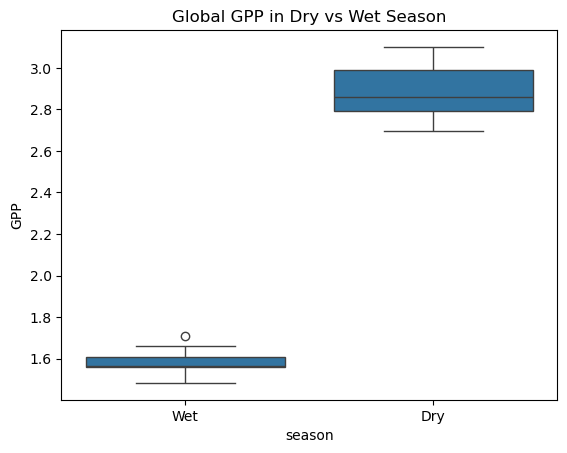

In [20]:
sns.boxplot(data=df_season, x="season", y="GPP")
plt.title("Global GPP in Dry vs Wet Season")
plt.show()

## 5.2. Seasonal Differences in the GPP–ET–VPD Relationships

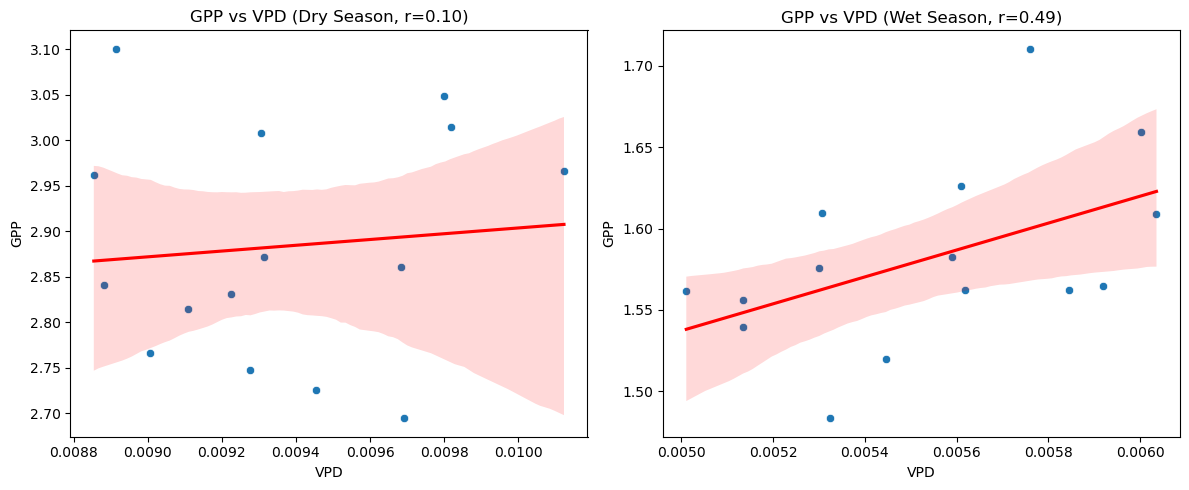

In [27]:
df_dry = df[df["season"].isin([ "Dry"])]
df_wet = df[df["season"].isin([ "Wet"])]

#
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# --- Panel 1: GPP vs VPD (dry season) ---
corr_gpp_vpd_dry = df_dry["GPP"].corr(df_dry["VPD"])

sns.scatterplot(ax=axes[0], data=df_dry, x="VPD", y="GPP")
sns.regplot(ax=axes[0], data=df_dry, x="VPD", y="GPP",
            scatter=False, color="red")
axes[0].set_title(f"GPP vs VPD (Dry Season, r={corr_gpp_vpd_dry:.2f})")
axes[0].set_xlabel("VPD")
axes[0].set_ylabel("GPP")


# --- Panel 2: GPP vs VPD (dry season) ---
corr_gpp_vpd_wet = df_wet["GPP"].corr(df_wet["VPD"])

sns.scatterplot(ax=axes[1], data=df_wet, x="VPD", y="GPP")
sns.regplot(ax=axes[1], data=df_wet, x="VPD", y="GPP",
            scatter=False, color="red")
axes[1].set_title(f"GPP vs VPD (Wet Season, r={corr_gpp_vpd_wet:.2f})")
axes[1].set_xlabel("VPD")
axes[1].set_ylabel("GPP")

plt.tight_layout()
plt.show()

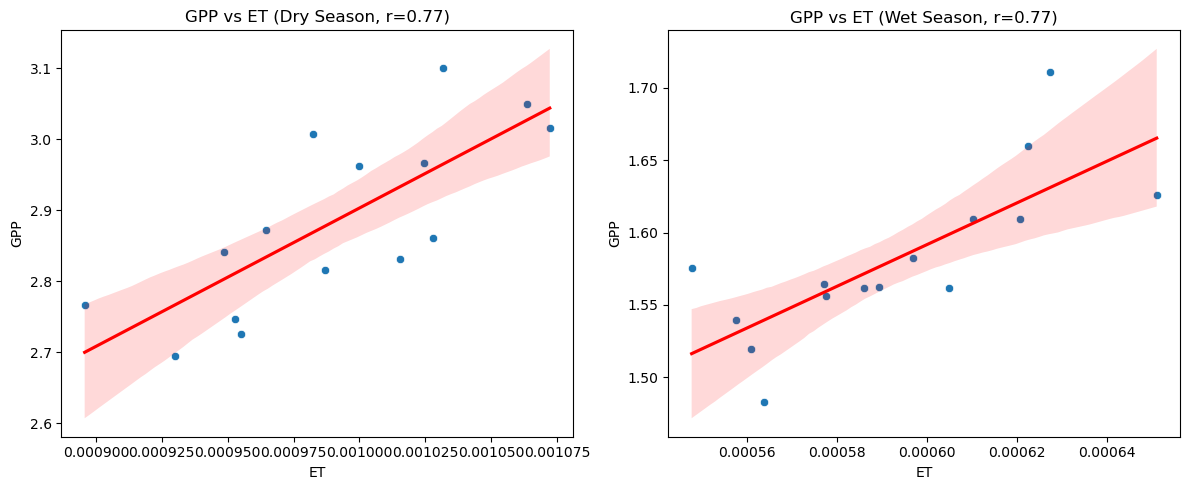

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# --- Panel 1: GPP vs VPD (dry season) ---
corr_gpp_vpd_dry = df_dry["GPP"].corr(df_dry["ET"])

sns.scatterplot(ax=axes[0], data=df_dry, x="ET", y="GPP")
sns.regplot(ax=axes[0], data=df_dry, x="ET", y="GPP",
            scatter=False, color="red")
axes[0].set_title(f"GPP vs ET (Dry Season, r={corr_gpp_vpd_dry:.2f})")
axes[0].set_xlabel("ET")
axes[0].set_ylabel("GPP")


# --- Panel 2: GPP vs VPD (dry season) ---
corr_gpp_et_wet = df_wet["GPP"].corr(df_wet["ET"])

sns.scatterplot(ax=axes[1], data=df_wet, x="ET", y="GPP")
sns.regplot(ax=axes[1], data=df_wet, x="ET", y="GPP",
            scatter=False, color="red")
axes[1].set_title(f"GPP vs ET (Wet Season, r={corr_gpp_et_wet:.2f})")
axes[1].set_xlabel("ET")
axes[1].set_ylabel("GPP")

plt.tight_layout()
plt.show()

## 5.3 Interpretation

1. Global GPP shows a strong seasonal contrast, with substantially higher values during the dry season than the wet season. Despite higher atmospheric dryness in dry months, GPP remains elevated because global-scale photosynthesis is dominated by the Northern Hemisphere growing season rather than local hydrological stress.
2. The scatterplots reveal clear seasonal differences.
   * GPP–VPD coupling is weak in the dry season (r ≈ 0.10), indicating that elevated VPD during peak growing months does not strongly suppress photosynthesis at the global mean scale. In contrast, the wet season shows a moderate positive correlation (r ≈ 0.49), suggesting that when the atmosphere is generally moist, small increases in VPD may be associated with slightly higher evaporative demand and photosynthesis.
   * By comparison, GPP–ET relationships remain consistently strong in both seasons (r ≈ 0.77). This indicates that water fluxes are a more robust predictor of global GPP than atmospheric dryness alone. Even during wetter months, variations in ET closely track changes in photosynthetic activity.
3. Overall, these results suggest that global photosynthesis is more tightly coupled to water supply (ET) than to atmospheric demand (VPD) .

# 6. Spatial Pattern Analysis

## 6.1. Spatial analysis

In [36]:
gpp_mean = gpp_ds.mean("time")
et_mean  = et_ds.mean("time")
vpd_mean = vpd_ds.mean("time")

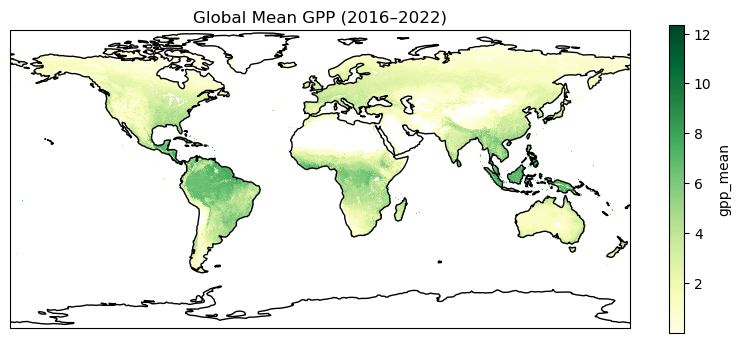

In [38]:
plt.figure(figsize=(10,4))
ax = plt.axes(projection=ccrs.PlateCarree())
gpp_mean.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="YlGn")
ax.coastlines()
plt.title("Global Mean GPP (2016–2020)")
plt.show()

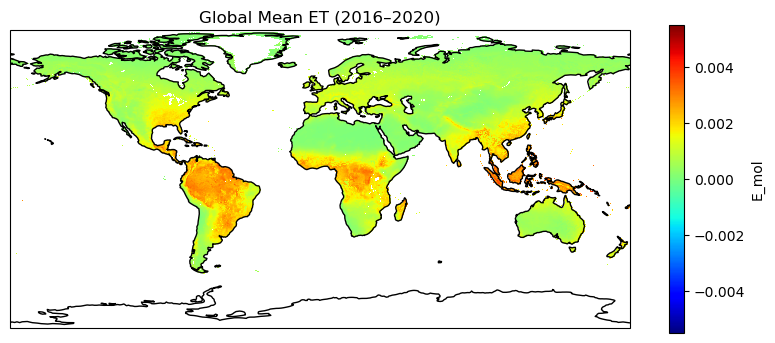

In [41]:
plt.figure(figsize=(10,4))
ax = plt.axes(projection=ccrs.PlateCarree())
et_mean.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="jet")
ax.coastlines()
plt.title("Global Mean ET (2016–2020)")
plt.show()

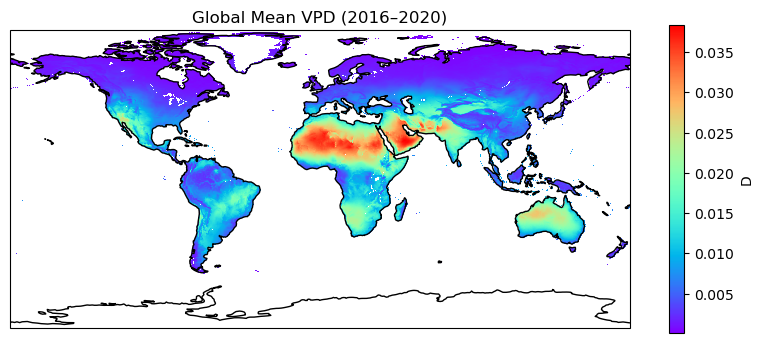

In [40]:
plt.figure(figsize=(10,4))
ax = plt.axes(projection=ccrs.PlateCarree())
vpd_mean.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="rainbow")
ax.coastlines()
plt.title("Global Mean VPD (2016–2020)")
plt.show()

## 6.2. Spatial Correlation Analysis

In [30]:
corr_gpp_et  = xr.corr(gpp_ds,et_ds, dim="time")

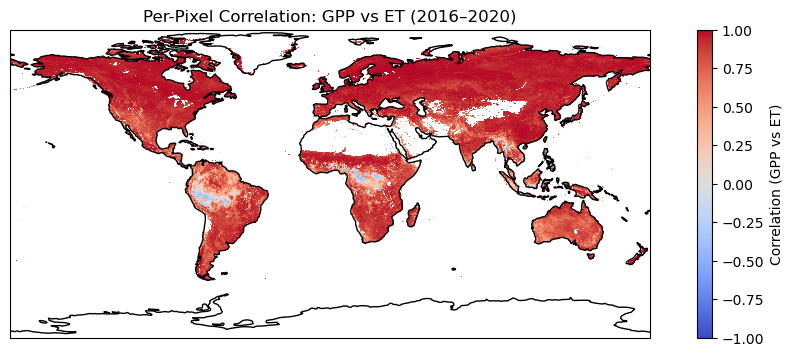

In [31]:
plt.figure(figsize=(12,4))

ax = plt.axes(projection=ccrs.PlateCarree())
corr_gpp_et.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",  # Red=Positive, Blue=Negative
    vmin=-1, vmax=1,
    cbar_kwargs={"label": "Correlation (GPP vs ET)"},
)
ax.add_feature(cfeature.COASTLINE)
ax.set_title("Per-Pixel Correlation: GPP vs ET (2016–2020)")
plt.show()

In [39]:
corr_gpp_vpd = xr.corr(gpp_ds, vpd_ds, dim="time")

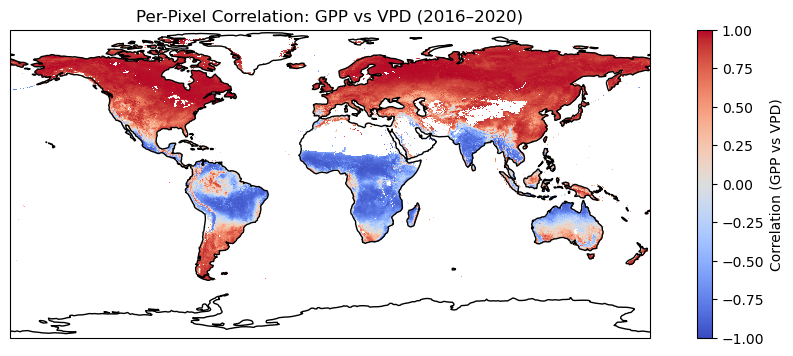

In [40]:
plt.figure(figsize=(12,4))

ax = plt.axes(projection=ccrs.PlateCarree())
corr_gpp_vpd.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
    vmin=-1, vmax=1,
    cbar_kwargs={"label": "Correlation (GPP vs VPD)"}
)
ax.add_feature(cfeature.COASTLINE)
ax.set_title("Per-Pixel Correlation: GPP vs VPD (2016–2020)")
plt.show()


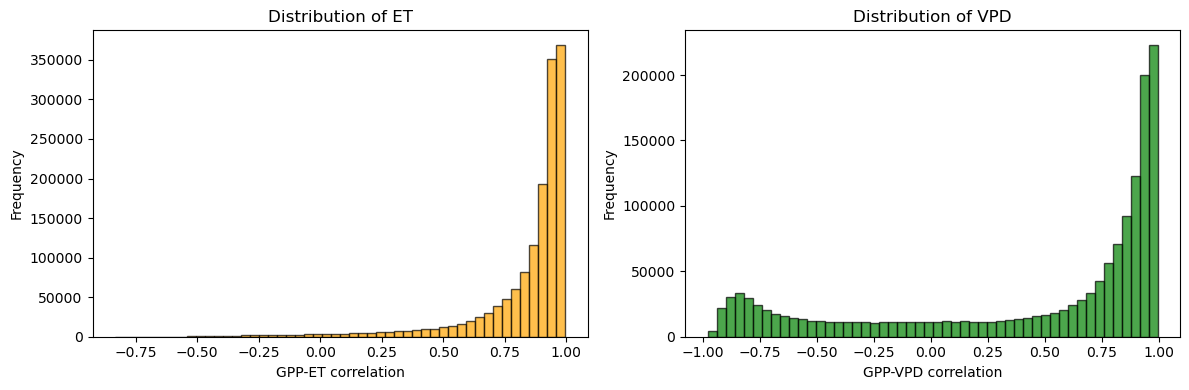

In [38]:
corr_et = corr_gpp_et.values
corr_vpd = corr_gpp_vpd.values

corr_et = corr_et[~np.isnan(corr_et)]
corr_vpd = corr_vpd[~np.isnan(corr_vpd)]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- Left：ET histgram ---
axes[0].hist(corr_et, bins=50, color="orange", alpha=0.7, edgecolor="black")
axes[0].set_title("Distribution of ET")
axes[0].set_xlabel("GPP-ET correlation")
axes[0].set_ylabel("Frequency")

# --- Right：VPD histgram ---
axes[1].hist(corr_vpd, bins=50, color="green", alpha=0.7, edgecolor="black")
axes[1].set_title("Distribution of VPD")
axes[1].set_xlabel("GPP-VPD correlation")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

## 6.3. Interpretation

The per-pixel correlations reveal two contrasting global patterns in how ecosystems respond to water availability and atmospheric dryness.
GPP–ET correlations are strongly positive across most vegetated regions, especially in the mid-latitudes and high-productivity zones (e.g., eastern North America, Europe, East Asia). 

In contrast, GPP–VPD correlations show a pronounced latitudinal divide. Large areas of the tropics, subtropics, and semi-arid regions exhibit strong negative correlations. Amazonia, central Africa, India, and northern Australia display especially strong VPD sensitivity. Meanwhile, high-latitude ecosystems show positive GPP–VPD correlations.

Together, these maps demonstrate that:

ET is a globally consistent positive driver of GPP, reflecting water-use dependence. VPD is a key stressor in warm and humid regions, but a growth-enabler in cold climates.

Global carbon–water coupling is highly spatially heterogeneous, shaped by climate regime and physiological constraints.

# 7. Conclusion
This analysis provides a global assessment of how ecosystem productivity (GPP) co-varies with evapotranspiration (ET) and atmospheric dryness (VPD) from 2016–2020. After aggregating satellite-derived observations globally, clear and coherent patterns emerge. First, all three variables exhibit strong and synchronized seasonal cycles, reflecting large-scale climatic controls on terrestrial photosynthesis. GPP and ET peak during the growing season, while VPD concurrently rises due to increased atmospheric demand, highlighting their shared sensitivity to global phenology and energy availability.

At the global mean level and per pixel, correlation analyses indicate that ET is consistently the strongest predictor of GPP. Nearly all vegetated regions show highly positive GPP–ET correlations, suggesting that water supply and surface energy balance remain dominant constraints on productivity. In contrast, GPP–VPD correlations vary sharply across regions: mid- and high-latitude ecosystems show positive correlations (VPD increasing with warmth during the growing season), whereas tropical and subtropical regions display strong negative correlations, indicating that atmospheric dryness suppresses carbon uptake where moisture stress is common.

Seasonal analyses further show that relationships shift across the year. In the dry season, GPP remains high and correlates strongly with ET but becomes weakly related to VPD. In the wet season, both ET and GPP decline, and VPD becomes a more informative predictor, capturing variations in atmospheric moisture demand.

Together, the global, seasonal, and spatial perspectives reveal a robust and consistent pattern: ecosystem productivity is jointly shaped by water availability and atmospheric dryness, but the strength and sign of these controls depend strongly on location and season.
